## Defining Validation metrics 

**The model is validated on the LFW data which is unrestricted, labeled outside data. The validation metrics which will be used to tune the model and evaluate its performance are summarised below:**

- True positive rate( Mean value of all true positive rates across all cross validation folds) and false positive rate.
        
- Accuracy, precision and recall for each fold in cross validation set.

- Area under ROC curve
- Using KFold cross validation, LFW validation data is evaluated taking the Euclidean distance as a metric. The pairwise distances from pairs of images are calculated. Best Euclidean distance values are computed that had the best performing accuracy on the LFW dataset per each fold in cross validation set.

- The true acceptance rate(rate that the faces are successfully accepted) is calculated when the false acceptance rate is 0.001(1 in 1000 images). The less the FAR value, the more difficult it is for the model). The default far target is 0.001.

- False Acceptance Rate per each fold in cross validation set.

**Below we are generating functions to calculate these metrics.**

In [ ]:
import numpy as np
from sklearn.metrics import auc
from sklearn.model_selection import KFold
from scipy import interpolate

def validation_LFW(dist_lfw,true_lfw, folds=5, target_far=1e-3):
    # Calculate ROC metrics
    tpr, fpr, precision, recall, accuracy, best_dist = \
      metrics_calculator(
          thresholds=np.arange(0, 4, 0.01), distances=dist_lfw, labels=true_lfw, folds=folds
      )

    AUC = auc(fpr, tpr)

    # Calculate validation rate
    
    val_thresholds = np.arange(0, 4, 0.001)
    num_pairs = min(len(true_lfw), len(dist_lfw))
    num_thresholds = len(val_thresholds)
    k_fold = KFold(n_splits=folds, shuffle=False)

    true_acceptance_rate = np.zeros(folds)
    false_acceptance_rate = np.zeros(folds)


    for kfold_num, (train_set, test_set) in enumerate(k_fold.split(np.arange(num_pairs))):
        # Find the euclidean distance threshold that gives false acceptance rate (far) = far_target
        false_acceptance_rate_train = np.zeros(num_thresholds)
        for threshold_index, threshold in enumerate(val_thresholds):
            # If distance is less than threshold, then prediction is set to True
            predict_issame = np.less(dist_lfw[train_set], threshold)
            false_accept = np.sum(np.logical_and(predict_issame, np.logical_not(true_lfw[train_set])))

            num_same = np.sum(true_lfw[train_set])
            num_diff = np.sum(np.logical_not(true_lfw[train_set]))

            if num_diff == 0:
                num_diff = 1
            if num_same == 0:
                return 0, 0

            false_acceptance_rate_train[threshold_index] = float(false_accept) / float(num_diff)

        if np.max(false_acceptance_rate_train) >= target_far:
            f = interpolate.interp1d(false_acceptance_rate_train, val_thresholds, kind='slinear')
            threshold = f(target_far)
        else:
            threshold = 0.0
            
        predict_issame = np.less(dist_lfw[test_set], threshold)

        true_accept = np.sum(np.logical_and(predict_issame, true_lfw[test_set]))
        false_accept = np.sum(np.logical_and(predict_issame, np.logical_not(true_lfw[test_set])))

        num_same = np.sum(true_lfw[test_set])
        num_diff = np.sum(np.logical_not(true_lfw[test_set]))

        if num_diff == 0:
            num_diff = 1
        if num_same == 0:
            return 0, 0

        true_acceptance_rate[kfold_num] = float(true_accept) / float(num_same)
        false_acceptance_rate[kfold_num] = float(false_accept) / float(num_diff)


    return tpr, fpr, precision, recall, accuracy, AUC, best_dist,\
      true_acceptance_rate, false_acceptance_rate

In [ ]:
def metrics_calculator(thresholds, distances, labels, folds=5):
    num_pairs = min(len(labels), len(distances))
    num_thresholds = len(thresholds)
    k_fold = KFold(n_splits=5, shuffle=False)

    tpr = np.zeros((5, num_thresholds))
    fpr = np.zeros((5, num_thresholds))
    precision,recall,accuracy,best_distances = np.zeros(5),np.zeros(5),np.zeros(5),np.zeros(5)

    indices = np.arange(num_pairs)

    for fold_index, (train_set, test_set) in enumerate(k_fold.split(indices)):
        # Find the best distance threshold for the k-fold cross validation using the train set
        accuracies_trainset = np.zeros(num_thresholds)
        for threshold_index, threshold in enumerate(thresholds):

          # If distance is less than threshold, then prediction is set to True
          predict_dist_lessthan_thresh = np.less(distances[train_set], threshold)

          true_positives = np.sum(np.logical_and(predict_dist_lessthan_thresh, labels[train_set]))
          false_positives = np.sum(np.logical_and(predict_dist_lessthan_thresh, np.logical_not(labels[train_set])))
          true_negatives = np.sum(np.logical_and(np.logical_not(predict_dist_lessthan_thresh), np.logical_not(labels[train_set])))
          false_negatives = np.sum(np.logical_and(np.logical_not(predict_dist_lessthan_thresh), labels[train_set]))


          accuracies_trainset[threshold_index] = float(true_positives + true_negatives) / threshold.size
        best_threshold_index = np.argmax(accuracies_trainset)

        for threshold_index, threshold in enumerate(thresholds):

          # If distance is less than threshold, then prediction is set to True
          predict_dist_lessthan_thresh = np.less(distances[test_set], threshold)

          true_positives = np.sum(np.logical_and(predict_dist_lessthan_thresh, labels[test_set]))
          false_positives = np.sum(np.logical_and(predict_dist_lessthan_thresh, np.logical_not(labels[test_set])))
          true_negatives = np.sum(np.logical_and(np.logical_not(predict_dist_lessthan_thresh), np.logical_not(labels[test_set])))
          false_negatives = np.sum(np.logical_and(np.logical_not(predict_dist_lessthan_thresh), labels[test_set]))

          # For dealing with Divide By Zero exception

          
          #calculating tpr and fpr
          if (true_positives + false_negatives) == 0:
            tpr[fold_index, threshold_index] = 0
            
          else:
            tpr[fold_index, threshold_index]=float(true_positives) / float(true_positives + false_negatives)
          
          if (false_positives + true_negatives) == 0:
            fpr[fold_index, threshold_index] = 0
            
          else:
            fpr[fold_index, threshold_index]=float(false_positives) / float(false_positives + true_negatives)

          # If distance is less than best threshold, then prediction is set to True
          predict_dist_lessthan_thresh = np.less(distances[test_set], thresholds[best_threshold_index])

          true_positives = np.sum(np.logical_and(predict_dist_lessthan_thresh, labels[test_set]))
          false_positives = np.sum(np.logical_and(predict_dist_lessthan_thresh, np.logical_not(labels[test_set])))
          true_negatives = np.sum(np.logical_and(np.logical_not(predict_dist_lessthan_thresh), np.logical_not(labels[test_set])))
          false_negatives = np.sum(np.logical_and(np.logical_not(predict_dist_lessthan_thresh), labels[test_set]))

          #calculating precision, recall and accuracy
          if (true_positives + false_positives) == 0:
            precision[fold_index] = 0
            
          else:
            precision[fold_index]=float(true_positives) / float(true_positives + false_positives)

          if (true_positives + false_negatives) == 0:
            recall[fold_index] = 0
            
          else:
            recall[fold_index]=float(true_positives) / float(true_positives + false_negatives)

        tpr_ = np.mean(tpr, 0)
        fpr_ = np.mean(fpr, 0)
        best_distances[fold_index] = thresholds[best_threshold_index]
        accuracy[fold_index] = float(true_positives + true_negatives) / distances[test_set].size

    return tpr_, fpr_, precision, recall, accuracy, best_distances   

**The function below will be used in the train code for validation data:**

In [ ]:
def validation_accuracy(pretrained_model,lfw_dataloader):
    
    pretrained_model.eval()
    with torch.no_grad():
        sqaured_distance = PairwiseDistance(p=2)
        dist_lfws, true_lfws = [], []

        print("--------Starting Validation on LFW dataset---------")

        for batch, (data_a, data_b, true_lfw) in enumerate(tqdm(lfw_dataloader,position=0,leave=True)):

            output_a, output_b = pretrained_model(data_a.cuda()), pretrained_model(data_b.cuda())

            dist_lfws.append(sqaured_distance.forward(output_a, output_b).cpu().detach().numpy())# Euclidean distance
            true_lfws.append(true_lfw.cpu().detach().numpy())

        true_lfws = np.array([subtrue for true_lfw in true_lfws for subtrue in true_lfw])
        dist_lfws = np.array([subdist for dist_lfw in dist_lfws for subdist in dist_lfw])

        true_positive_rate, false_positive_rate, precision, recall, accuracy, AUC, best_distances, \
        true_acceptance_rate, false_acceptance_rate = validation_LFW(dist_lfw=dist_lfws,true_lfw=true_lfws,target_far=1e-3)

        print('Accuracy: {:.2f} %'.format(np.mean(accuracy)*100))
        return np.mean(accuracy),np.mean(precision), np.mean(recall),np.mean(AUC),np.mean(best_distances),np.mean(true_acceptance_rate),np.mean(false_acceptance_rate)

## Models Architecture

**Now that the preprocessing of the data has been done and the evaluation metrics have been defined, we proceed with designing two models.**

- Model 1: CNN 

This model has 3 Convolutional layers & 2 Fully-connected layers

- Model 2: Inception ResNetV1

This model is a hybrid network inspired by both the inception model and the resnet model. We will be pruning this state of the art model having  exceptional capabilities in facial recognition.



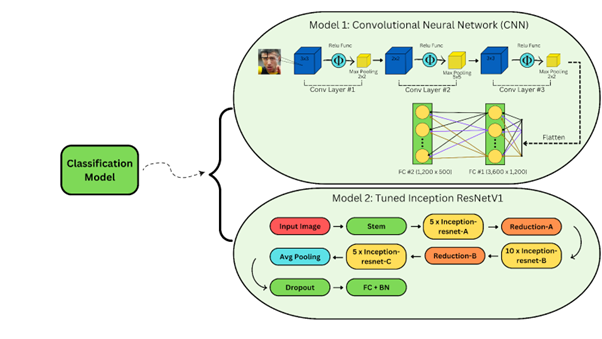

## Training the models

### Generating csv file

The below code is used to generate csv files of cropped images in train set required by the train function.

In [ ]:
DATA_DIR = data_dir+'_cropped'

generate_csv_file(DATA_DIR, "dataset.csv")


Loading image paths ...
Number of files: 801714

Generating csv file ...


100%|██████████| 801714/801714 [00:05<00:00, 155426.90it/s]



Done! Elapsed time: 0.11 minutes.


### Forward pass function

**The below code is used to concatenate the input images into one tensor because doing multiple forward passes would create weird GPU memory allocation behaviours later on during training which would cause GPU Out of Memory issues. It splits the embeddings into anchor, positive and negative (in the form of triplets). The anchor image is that of a specific person and positive image is anothe rimage of the same person and negative image is of a different person.**

In [ ]:
def forward_pass(anc_imgs, pos_imgs, neg_imgs, model, batch_size):
   
    imgs = torch.cat((anc_imgs, pos_imgs, neg_imgs))  # Must be a tuple of Torch Tensors

    imgs = imgs.cuda()
    embeddings = model(imgs)

    # Split the embeddings into Anchor, Positive, and Negative embeddings
    anc_embeddings = embeddings[:batch_size]
    pos_embeddings = embeddings[batch_size: batch_size * 2]
    neg_embeddings = embeddings[batch_size * 2:]

    return anc_embeddings, pos_embeddings, neg_embeddings, model


### Saving model training checkpoints
**The below is used to save model training checkpoints.**

In [ ]:
!mkdir -p datasets\generated_triplets logs model_training_checkpoints

ITERATIONS_PER_EPOCH = 1000
IMAGE_SIZE = 160 
DATA_TRANSFORMS = data_transforms = transforms.Compose([
        transforms.Resize(size=IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=5),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=dataset_mean,
            std=dataset_std
        )
    ])

MARGIN = 1
MDOEL_ARCH = 'InceptionResnetV1'
EMBEDDING_DIM = 512

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file datasets\generated_triplets already exists.
Error occurred while processing: datasets\generated_triplets.
A subdirectory or file logs already exists.
Error occurred while processing: logs.
A subdirectory or file model_training_checkpoints already exists.
Error occurred while processing: model_training_checkpoints.


### Main train function

In [ ]:
import matplotlib.pyplot as plt
import math
def train(model, optimizer, epochs=50, batch_size=32):
    lfw_dataloader= load_data_for_evaluation(image_size=160, batch_size=100, num_workers=0)
    print("Training using triplet loss starting for {} epochs:\n".format(epochs))
    total_triplet_loss_ls,train_acc_ls,val_acc_ls=[],[],[]
    val_precision_ls,val_recall_ls,val_auc_ls=[],[],[]

    for epoch in range(epochs):
        total_loss=0
        num_valid_training_triplets = 0
        l2_distance = PairwiseDistance(p=2)
        # Re-instantiate training dataloader to generate a triplet list for this training epoch
        train_dataloader = torch.utils.data.DataLoader(
            dataset=TripletFaceDataset(
                root_dir=DATA_DIR,
                training_dataset_csv_path="dataset.csv",
                num_triplets=ITERATIONS_PER_EPOCH * batch_size,
                num_human_identities_per_batch=64,
                triplet_batch_size=batch_size,
                epoch=epoch,
                transform=data_transforms
            ),
            batch_size=batch_size,
            num_workers=0,
            shuffle=True
        )

        # Training pass
        model.train()
        progress_bar = enumerate(tqdm(train_dataloader, position=0, leave=True))

        for batch_idx, (batch_sample) in progress_bar:

            # Forward pass - compute embeddings
            # each batch is a dictionary of anc_images, positive_images, and negative_images
            anc_embeddings, pos_embeddings, neg_embeddings, model = forward_pass(
                batch_sample['anc_img'], batch_sample['pos_img'], batch_sample['neg_img'],
                model=model, batch_size=batch_size
            )

            pos_dists = l2_distance.forward(anc_embeddings, pos_embeddings)
            neg_dists = l2_distance.forward(anc_embeddings, neg_embeddings)

            # Hard Negative triplet selection (negative_distance - positive_distance < margin)
            all = (neg_dists - pos_dists < MARGIN).cpu().numpy().flatten()
            valid_triplets = np.where(all == 1)

            anc_valid_embeddings = anc_embeddings[valid_triplets]
            pos_valid_embeddings = pos_embeddings[valid_triplets]
            neg_valid_embeddings = neg_embeddings[valid_triplets]

            # Calculate triplet loss
            triplet_loss = TripletLoss(margin=MARGIN).forward(
                anchor=anc_valid_embeddings,
                positive=pos_valid_embeddings,
                negative=neg_valid_embeddings
            )
            

            # Calculating number of triplets actually used for training
            num_valid_training_triplets += len(anc_valid_embeddings)

            # Do the backpropogation and update the weights
            optimizer.zero_grad()
            triplet_loss.backward()
            optimizer.step()
            
            triplet_loss=triplet_loss.cpu().detach().item()
            
            #print(triplet_loss)
            
            if math.isnan(triplet_loss):
                triplet_loss=0
                
            total_loss+=triplet_loss
            
        
        total_triplet_loss= total_loss/num_valid_training_triplets
        total_triplet_loss_ls.append(total_triplet_loss)
        train_acc=1-num_valid_training_triplets/(ITERATIONS_PER_EPOCH * batch_size)
        train_acc_ls.append(train_acc)
        
        val_metrics=validation_accuracy(model,lfw_dataloader)
        val_acc_ls.append(val_metrics[0])
        val_precision_ls.append(val_metrics[1])
        val_recall_ls.append(val_metrics[2])
        val_auc_ls.append(val_metrics[3])
        
    #plt.plot()
    

        # Save model checkpoint
        state = {
            'epoch': epoch,
            'embedding_dimension': EMBEDDING_DIM,
            'batch_size_training': batch_size,
            'model_state_dict': model.state_dict(),
            'model_architecture': MDOEL_ARCH,
            'optimizer_model_state_dict': optimizer.state_dict(),
            'validation_metrics': val_metrics,
            'num_valid_training_triplets':num_valid_training_triplets,
            'train_accuracy':train_acc,
            'train_loss':total_triplet_loss
            
            # 'best_distance_threshold': np.mean(best_distances)
        }
        torch.save(state, 'model_training_checkpoints/model_{}_triplet_epoch_{}.pt'.format(
                MDOEL_ARCH,
                epoch
            )
        )
    #train loss curves
    #Plotting the train/validation accuracies and loss curves:
    plt.title("Train loss")
    n = len(total_triplet_loss_ls) # number of epochs
    plt.plot(range(1,n+1), total_triplet_loss_ls, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    
    n = len(val_acc_ls) # number of epochs
    plt.plot(range(1,n+1), val_acc_ls, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("accuracy")
    plt.title("Validation Accuracy")
    plt.show()
    
    n = len(train_acc_ls) # number of epochs
    plt.plot(range(1,n+1), train_acc_ls, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("accuracy")
    plt.title("Train Accuracy")
    plt.legend(loc='best')
    plt.show()
    
    plt.title("Other Validation Metrics")
    n = len(val_precision_ls) # number of epochs
    plt.plot(range(1,n+1), val_precision_ls, label="Precision")
    plt.plot(range(1,n+1), val_recall_ls, label="Recall")
    plt.plot(range(1,n+1), val_auc_ls, label="AUC")
    plt.xlabel("Epoch")
    plt.ylabel("Metrics")
    plt.legend(loc='best')
    plt.show()

### Training our Designed CNN Architecture Model

In [ ]:
class my_CNN(nn.Module): 
  def __init__(self, Input_channels=[3,20,50], Output_channels=[20,50,100], \
               Kernel=[3,2,3], Stride=[1,1,1]):
    super(my_CNN, self).__init__()
    self.name = "my_CNN"

    # first convolutional layer--> activation function: Relu-->MaxPool 2D  
    self.convlayer1= nn.Conv2d(in_channels=Input_channels[0], out_channels=Output_channels[0], kernel_size=Kernel[0], stride=Stride[0])
    
    self.pool1= nn.MaxPool2d(kernel_size=2, stride=2)

    #Second convolutional layer--> activation function: Relu-->MaxPool 2D
    self.convlayer2= nn.Conv2d(in_channels=Input_channels[1], out_channels=Output_channels[1], kernel_size=Kernel[1], stride=Stride[1])
    
    self.pool2= nn.MaxPool2d(kernel_size=5, stride=5)

    #Third convolutional layer--> activation function: Relu-->MaxPool 2D
    self.convlayer3= nn.Conv2d(in_channels=Input_channels[2], out_channels=Output_channels[2], kernel_size=Kernel[2], stride=Stride[2])
    
    self.pool3= nn.MaxPool2d(kernel_size=2, stride=2)

    #calculating input to 1st fully connected layer:  

    #For any other values of in/output channels, kernel sizes
    #The input to the fully connected layer can be calculated as:
    self.a= 160-(Kernel[0]-1) #output from the first conv layer
    self.b=math.floor(0.5*(self.a)) #output from the first pooling layer

    self.c= self.b-(Kernel[1]-1) #output from the second conv layer
    self.d=math.floor(0.2*(self.c)) #output from the second pooling layer

    self.e= self.d-(Kernel[2]-1) #output from the third conv layer
    self.f=math.floor(0.5*(self.e)) #output from the third pooling layer

    self.fc1 = nn.Linear(3600, 1200) #first fully connected layer
    self.fc2 = nn.Linear(1200, 500) #second fully connected layer

  def forward(self, x):
    #ReLU activation function between conv layers and maxpool layers
    x = self.pool1(F.relu(self.convlayer1(x)))
    x = self.pool2(F.relu(self.convlayer2(x)))
    x = self.pool3(F.relu(self.convlayer3(x)))
    #flatten the data for fclayer
    x = x.view(-1, 3600)
    #ReLU on the fc layer 
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

**The below code is used to save model training checkpoints for the CNN Model:**

In [ ]:
!mkdir -p datasets\generated_triplets logs model_training_checkpoints

ITERATIONS_PER_EPOCH = 1000
IMAGE_SIZE = 160 
DATA_TRANSFORMS = data_transforms = transforms.Compose([
        transforms.Resize(size=IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=5),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=dataset_mean,
            std=dataset_std
        )
    ])

MARGIN = 1
MDOEL_ARCH = 'my_CNN'
EMBEDDING_DIM = 512

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file datasets\generated_triplets already exists.
Error occurred while processing: datasets\generated_triplets.
A subdirectory or file logs already exists.
Error occurred while processing: logs.
A subdirectory or file model_training_checkpoints already exists.
Error occurred while processing: model_training_checkpoints.


Skipped 330 image pairs
Training using triplet loss starting for 50 epochs:


Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1369.57it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [02:58<00:00,  5.62it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:17<00:00,  3.28it/s]


Accuracy: 67.04 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1414.11it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [02:54<00:00,  5.72it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:17<00:00,  3.30it/s]


Accuracy: 64.66 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1402.21it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [02:52<00:00,  5.81it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:18<00:00,  3.11it/s]


Accuracy: 67.58 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:01<00:00, 569.23it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [03:12<00:00,  5.20it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:18<00:00,  3.16it/s]


Accuracy: 69.51 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1418.12it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [03:00<00:00,  5.53it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:17<00:00,  3.22it/s]


Accuracy: 67.09 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1432.34it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [02:53<00:00,  5.75it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:17<00:00,  3.24it/s]


Accuracy: 70.85 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:01<00:00, 608.69it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [02:58<00:00,  5.59it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:18<00:00,  3.15it/s]


Accuracy: 72.49 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1436.46it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [02:56<00:00,  5.67it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:18<00:00,  3.13it/s]


Accuracy: 71.76 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1392.44it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [03:00<00:00,  5.54it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:18<00:00,  3.10it/s]


Accuracy: 72.20 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1398.29it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [03:11<00:00,  5.23it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:18<00:00,  3.01it/s]


Accuracy: 72.38 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1397.08it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [03:24<00:00,  4.89it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:18<00:00,  3.08it/s]


Accuracy: 72.77 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1274.88it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [03:18<00:00,  5.04it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:18<00:00,  3.14it/s]


Accuracy: 72.57 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1400.91it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [02:59<00:00,  5.58it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:17<00:00,  3.20it/s]


Accuracy: 73.05 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:01<00:00, 562.41it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [03:01<00:00,  5.52it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:18<00:00,  3.15it/s]


Accuracy: 73.33 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1412.11it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [02:55<00:00,  5.70it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:17<00:00,  3.23it/s]


Accuracy: 72.61 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1416.11it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [02:55<00:00,  5.70it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:18<00:00,  3.15it/s]


Accuracy: 74.32 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1442.68it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [03:16<00:00,  5.08it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:18<00:00,  3.03it/s]


Accuracy: 71.76 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1361.85it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [03:20<00:00,  4.99it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:17<00:00,  3.17it/s]


Accuracy: 74.13 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1437.95it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [03:21<00:00,  4.97it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:18<00:00,  3.01it/s]


Accuracy: 74.25 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1325.96it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [03:15<00:00,  5.12it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:18<00:00,  3.10it/s]


Accuracy: 73.12 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:01<00:00, 520.60it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [03:22<00:00,  4.94it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:18<00:00,  3.13it/s]


Accuracy: 72.84 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1438.53it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [03:16<00:00,  5.08it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:18<00:00,  3.05it/s]


Accuracy: 73.40 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1440.60it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [03:08<00:00,  5.31it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:19<00:00,  3.00it/s]


Accuracy: 73.03 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1419.12it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [03:06<00:00,  5.36it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:18<00:00,  3.07it/s]


Accuracy: 74.36 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1377.10it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [02:57<00:00,  5.63it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:17<00:00,  3.19it/s]


Accuracy: 75.06 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1243.50it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [03:18<00:00,  5.05it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:18<00:00,  3.13it/s]


Accuracy: 75.34 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1392.78it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [03:16<00:00,  5.09it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:17<00:00,  3.19it/s]


Accuracy: 74.32 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:01<00:00, 539.84it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [03:00<00:00,  5.53it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:17<00:00,  3.20it/s]


Accuracy: 75.13 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1450.06it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [03:03<00:00,  5.45it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:18<00:00,  3.14it/s]


Accuracy: 75.26 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1322.45it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [03:03<00:00,  5.46it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:17<00:00,  3.22it/s]


Accuracy: 75.57 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:01<00:00, 523.34it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [03:00<00:00,  5.54it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:17<00:00,  3.30it/s]


Accuracy: 75.36 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1519.97it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [02:44<00:00,  6.08it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:17<00:00,  3.20it/s]


Accuracy: 74.67 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1487.76it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [02:42<00:00,  6.17it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:16<00:00,  3.46it/s]


Accuracy: 75.61 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1501.16it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [02:43<00:00,  6.10it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:16<00:00,  3.47it/s]


Accuracy: 73.51 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:01<00:00, 591.42it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [02:43<00:00,  6.11it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:16<00:00,  3.38it/s]


Accuracy: 75.36 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1483.34it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [02:43<00:00,  6.11it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:17<00:00,  3.35it/s]


Accuracy: 74.69 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1483.28it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [02:55<00:00,  5.71it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:18<00:00,  3.06it/s]


Accuracy: 75.94 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:01<00:00, 506.54it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [03:10<00:00,  5.25it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:20<00:00,  2.74it/s]


Accuracy: 75.50 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1247.17it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [03:14<00:00,  5.15it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:18<00:00,  3.11it/s]


Accuracy: 75.57 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1422.35it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [02:47<00:00,  5.97it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:16<00:00,  3.37it/s]


Accuracy: 74.76 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1463.82it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [02:44<00:00,  6.07it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:16<00:00,  3.42it/s]


Accuracy: 75.15 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:01<00:00, 546.08it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [02:41<00:00,  6.21it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:16<00:00,  3.42it/s]


Accuracy: 75.50 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1501.16it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [02:41<00:00,  6.20it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:16<00:00,  3.45it/s]


Accuracy: 74.20 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1470.35it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [02:43<00:00,  6.13it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:16<00:00,  3.40it/s]


Accuracy: 76.16 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:01<00:00, 561.02it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [02:44<00:00,  6.10it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:17<00:00,  3.27it/s]


Accuracy: 75.13 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1476.77it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [02:45<00:00,  6.05it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:17<00:00,  3.30it/s]


Accuracy: 75.77 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1468.33it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [02:46<00:00,  6.01it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:17<00:00,  3.34it/s]


Accuracy: 75.96 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1467.28it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [02:48<00:00,  5.95it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:17<00:00,  3.34it/s]


Accuracy: 75.78 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:01<00:00, 663.63it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [02:51<00:00,  5.83it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:17<00:00,  3.28it/s]


Accuracy: 75.17 %

Generating 24000 triplets ...


100%|██████████| 1000/1000 [00:00<00:00, 1457.40it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [02:49<00:00,  5.90it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:17<00:00,  3.27it/s]


Accuracy: 76.28 %


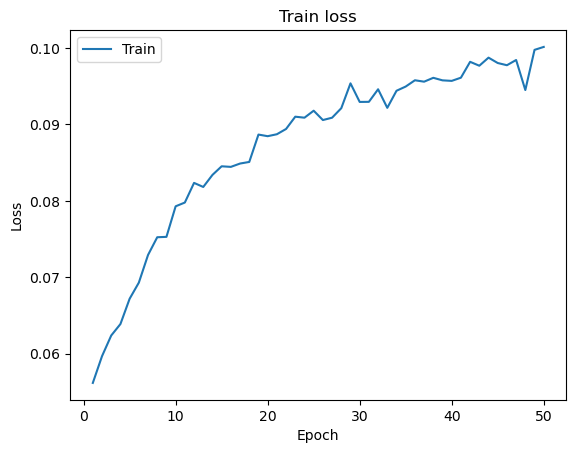

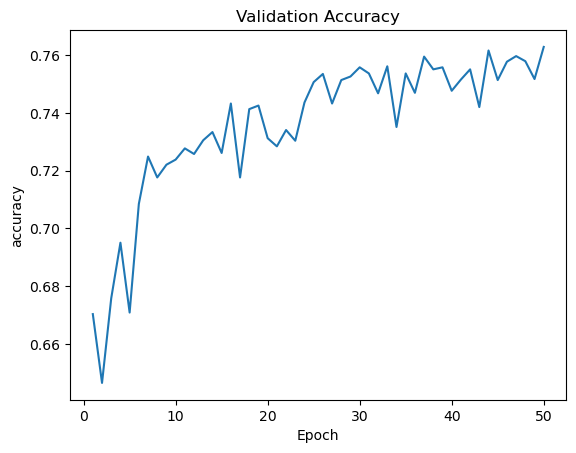

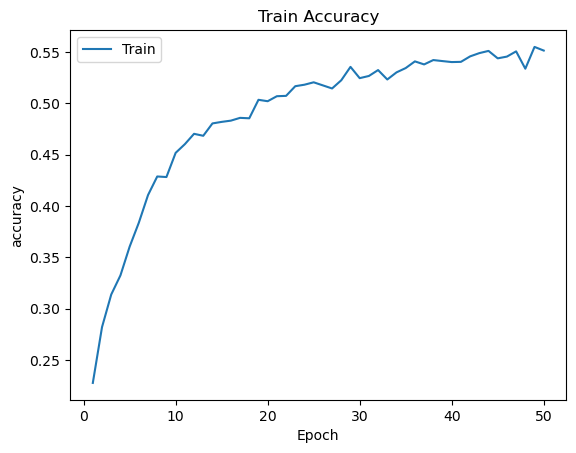

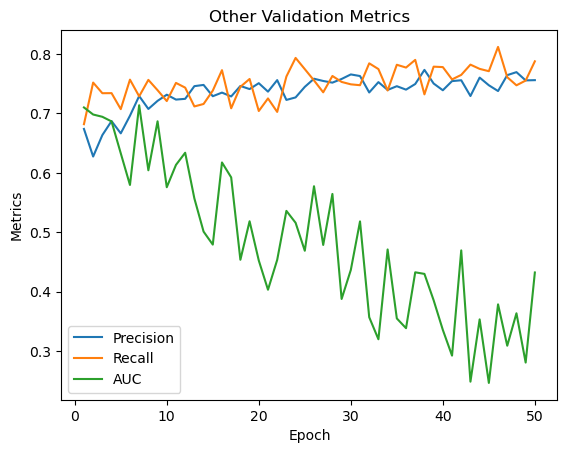

In [ ]:
model=my_CNN()
if torch.cuda.is_available():
    model.cuda()
def get_optimizer(model, learning_rate=0.001):
    return optim.Adam(
              params=model.parameters(),
              lr=learning_rate,
              betas=(0.9, 0.999),
              eps=1e-08,
              amsgrad=False,
              weight_decay=1e-5
          )
  
train(model, get_optimizer(model), 50, batch_size=24)

**Printing the final Validation metrics for CNN:**

In [ ]:
PATH='C:\\Users\\bhagyashreekeswani\\Desktop\\DL_Project\\all_checkpoints\\model_training_checkpoints_cnn\\model_my_CNN_triplet_epoch_49.pt'
final_metrics_cnn=torch.load(PATH)['validation_metrics']
print('-----------The final validation metrics for CNN model after 50 epochs-----------')
print('Accuracy: {:.2f} %'.format(final_metrics_cnn[0]*100))
print('Precision: {:.3f}'.format(final_metrics_cnn[1]))
print('Recall: {:.3f}'.format(final_metrics_cnn[2]))
print('Area Under ROC: {:.3f}'.format(final_metrics_cnn[3]))
print('Best distance threshold: {:.3f}'.format(final_metrics_cnn[4]))
print('True acceptance rate: {:.6f}'.format(final_metrics_cnn[5]))
print('False acceptance rate: {:.6f}'.format(final_metrics_cnn[6]))

-----------The final validation metrics for CNN model after 50 epochs-----------
Accuracy: 76.28 %
Precision: 0.756
Recall: 0.788
Area Under ROC: 0.432
Best distance threshold: 3.074
True acceptance rate: 0.017010
False acceptance rate: 0.001070


In [ ]:
#clear cache to avoid running out of memory
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

  0%|          | 0/1000 [01:12<?, ?it/s]


### Training InceptionResnetV1 model 

**Note: As specified in the rubric, just 50 runs have been shown below. For the rest of the runs, the model training checkpoints were used to display the final validation/train accuracies and other metrics.**

Skipped 330 image pairs
Training using triplet loss starting for 50 epochs:


Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1272.04it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [11:06<00:00,  1.50it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:34<00:00,  1.63it/s]


Accuracy: 66.70 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:01<00:00, 662.77it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [11:08<00:00,  1.50it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:35<00:00,  1.60it/s]


Accuracy: 66.83 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1273.27it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [11:21<00:00,  1.47it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:36<00:00,  1.55it/s]


Accuracy: 68.43 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1335.87it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [11:07<00:00,  1.50it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.68it/s]


Accuracy: 70.76 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1319.63it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:53<00:00,  1.53it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.69it/s]


Accuracy: 72.29 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1353.79it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:46<00:00,  1.55it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.69it/s]


Accuracy: 74.27 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1371.14it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:48<00:00,  1.54it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:34<00:00,  1.66it/s]


Accuracy: 74.02 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1171.55it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:48<00:00,  1.54it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:34<00:00,  1.68it/s]


Accuracy: 74.07 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1431.37it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:47<00:00,  1.54it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:34<00:00,  1.67it/s]


Accuracy: 76.01 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1308.61it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:46<00:00,  1.55it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.68it/s]


Accuracy: 75.49 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1398.29it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:47<00:00,  1.54it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.69it/s]


Accuracy: 76.51 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1455.28it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:47<00:00,  1.55it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.69it/s]


Accuracy: 78.20 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:01<00:00, 922.10it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:47<00:00,  1.54it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.70it/s]


Accuracy: 77.34 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1379.53it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:44<00:00,  1.55it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:34<00:00,  1.67it/s]


Accuracy: 77.32 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1256.34it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:43<00:00,  1.55it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.69it/s]


Accuracy: 76.77 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1391.98it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:43<00:00,  1.55it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.69it/s]


Accuracy: 76.60 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1450.33it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:44<00:00,  1.55it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.69it/s]


Accuracy: 78.31 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1446.25it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:51<00:00,  1.53it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:35<00:00,  1.61it/s]


Accuracy: 77.23 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:01<00:00, 594.04it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:53<00:00,  1.53it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.70it/s]


Accuracy: 74.99 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1385.27it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [11:11<00:00,  1.49it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.68it/s]


Accuracy: 78.82 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1285.94it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:51<00:00,  1.54it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.69it/s]


Accuracy: 77.00 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1452.34it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:52<00:00,  1.53it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.69it/s]


Accuracy: 78.80 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1274.52it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [11:01<00:00,  1.51it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.68it/s]


Accuracy: 78.20 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:01<00:00, 518.24it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:44<00:00,  1.55it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.69it/s]


Accuracy: 78.43 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1302.54it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:42<00:00,  1.56it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.68it/s]


Accuracy: 78.62 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1298.41it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:41<00:00,  1.56it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.70it/s]


Accuracy: 79.61 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1380.57it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [11:02<00:00,  1.51it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.70it/s]


Accuracy: 78.57 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1405.86it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:59<00:00,  1.52it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:34<00:00,  1.65it/s]


Accuracy: 78.69 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1360.79it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:44<00:00,  1.55it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.73it/s]


Accuracy: 78.98 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:01<00:00, 581.02it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:44<00:00,  1.55it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.72it/s]


Accuracy: 78.92 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1317.75it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:44<00:00,  1.55it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.68it/s]


Accuracy: 79.72 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1382.64it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:42<00:00,  1.56it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.71it/s]


Accuracy: 78.32 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1422.58it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:41<00:00,  1.56it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.69it/s]


Accuracy: 78.36 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1429.19it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:40<00:00,  1.56it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.72it/s]


Accuracy: 78.75 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:01<00:00, 635.82it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:38<00:00,  1.57it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.69it/s]


Accuracy: 79.29 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1449.70it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:43<00:00,  1.56it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.70it/s]


Accuracy: 79.01 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1395.58it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:44<00:00,  1.55it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:34<00:00,  1.67it/s]


Accuracy: 78.84 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1440.60it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:42<00:00,  1.56it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:34<00:00,  1.64it/s]


Accuracy: 79.29 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1481.09it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:42<00:00,  1.56it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.69it/s]


Accuracy: 79.38 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1366.00it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:54<00:00,  1.53it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:34<00:00,  1.63it/s]


Accuracy: 79.82 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:02<00:00, 482.27it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:44<00:00,  1.55it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.70it/s]


Accuracy: 78.94 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1427.29it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [11:19<00:00,  1.47it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:35<00:00,  1.59it/s]


Accuracy: 79.89 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1361.03it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:55<00:00,  1.53it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:35<00:00,  1.61it/s]


Accuracy: 79.89 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1319.12it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:42<00:00,  1.56it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.69it/s]


Accuracy: 79.14 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1371.97it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:40<00:00,  1.56it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.71it/s]


Accuracy: 78.98 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:01<00:00, 576.04it/s]


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:40<00:00,  1.56it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.70it/s]


Accuracy: 79.14 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1433.40it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:41<00:00,  1.56it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.69it/s]


Accuracy: 79.56 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1474.59it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:44<00:00,  1.55it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.70it/s]


Accuracy: 79.86 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1476.10it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:41<00:00,  1.56it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.69it/s]


Accuracy: 79.95 %

Generating 24000 triplets ...



100%|██████████| 1000/1000 [00:00<00:00, 1437.80it/s][A


Saving training triplets list in 'datasets/generated_triplets' directory ...
Training triplets' list Saved!



100%|██████████| 1000/1000 [10:42<00:00,  1.56it/s]


--------Starting Validation on LFW dataset---------


100%|██████████| 57/57 [00:33<00:00,  1.69it/s]


Accuracy: 79.81 %


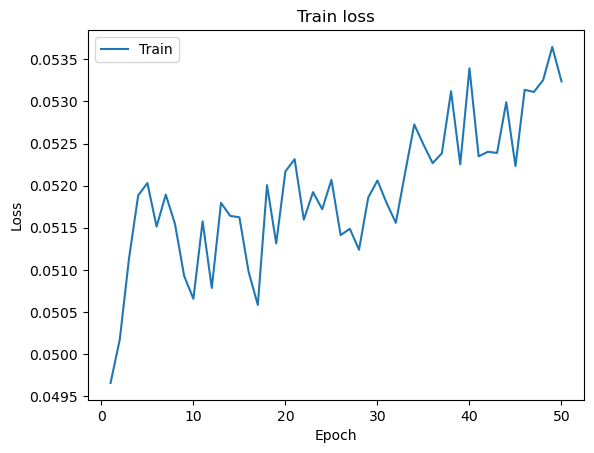

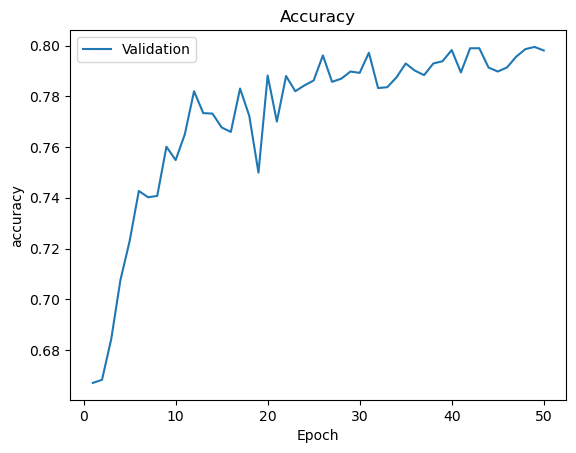

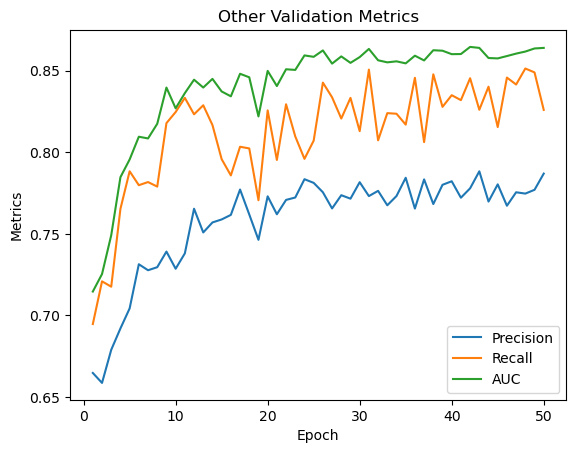

In [ ]:
inception_model = InceptionResnetV1(
    pretrained='vggface2',
).to('cuda')
def get_optimizer(model, learning_rate=0.001):
    return optim.Adam(
              params=model.parameters(),
              lr=learning_rate,
              betas=(0.9, 0.999),
              eps=1e-08,
              amsgrad=False,
              weight_decay=1e-5
          )
  
train(inception_model, get_optimizer(inception_model), 50, batch_size=24)

**Plotting all runs graphs combined from the saved checkpoints:**

In [ ]:
total_triplet_loss_ls, val_acc_ls, train_acc_ls = [], [], []
val_precision_ls, val_recall_ls, val_auc_ls = [], [], []

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
!cp /gdrive/MyDrive/all_checkpoints.zip .

Mounted at /gdrive


In [ ]:
!unzip ./all_checkpoints.zip

Archive:  ./all_checkpoints.zip
   creating: all_checkpoints/
   creating: all_checkpoints/model_training_checkpoints1/
  inflating: all_checkpoints/model_training_checkpoints1/model_InceptionResnetV1_triplet_epoch_0.pt  
  inflating: all_checkpoints/model_training_checkpoints1/model_InceptionResnetV1_triplet_epoch_1.pt  
  inflating: all_checkpoints/model_training_checkpoints1/model_InceptionResnetV1_triplet_epoch_10.pt  
  inflating: all_checkpoints/model_training_checkpoints1/model_InceptionResnetV1_triplet_epoch_11.pt  
  inflating: all_checkpoints/model_training_checkpoints1/model_InceptionResnetV1_triplet_epoch_12.pt  
  inflating: all_checkpoints/model_training_checkpoints1/model_InceptionResnetV1_triplet_epoch_13.pt  
  inflating: all_checkpoints/model_training_checkpoints1/model_InceptionResnetV1_triplet_epoch_14.pt  
  inflating: all_checkpoints/model_training_checkpoints1/model_InceptionResnetV1_triplet_epoch_15.pt  
  inflating: all_checkpoints/model_training_checkpoints1/m

In [ ]:
# LIST_OF_RUNS = ['./all_checkpoints/'+x for x in os.listdir('./all_checkpoints/')]
# LIST_OF_RUNS.sort()
LIST_OF_RUNS = ['./all_checkpoints/model_training_checkpoints5', './all_checkpoints/model_training_checkpoints3_imp', './all_checkpoints/model_training_checkpoints4']
print(LIST_OF_RUNS)
for run_folder in LIST_OF_RUNS:
  checkpoints = os.listdir(run_folder)
  checkpoints.sort(key=lambda x: int(x.replace(".pt", "").replace("model_InceptionResnetV1_triplet_epoch_", "")))
  print(checkpoints)
  for checkpoint in checkpoints:
    checkpoint_dict = torch.load(run_folder+'/'+checkpoint, map_location=torch.device('cpu'))
    total_triplet_loss_ls.append(checkpoint_dict['train_loss'])
    train_acc_ls.append(checkpoint_dict['train_accuracy'])
    val_acc_ls.append(checkpoint_dict['validation_metrics'][0])
    val_precision_ls.append(checkpoint_dict['validation_metrics'][1])
    val_recall_ls.append(checkpoint_dict['validation_metrics'][2])
    val_auc_ls.append(checkpoint_dict['validation_metrics'][3])

['./all_checkpoints/model_training_checkpoints5', './all_checkpoints/model_training_checkpoints3_imp', './all_checkpoints/model_training_checkpoints4']
['model_InceptionResnetV1_triplet_epoch_0.pt', 'model_InceptionResnetV1_triplet_epoch_1.pt', 'model_InceptionResnetV1_triplet_epoch_2.pt', 'model_InceptionResnetV1_triplet_epoch_3.pt', 'model_InceptionResnetV1_triplet_epoch_4.pt', 'model_InceptionResnetV1_triplet_epoch_5.pt', 'model_InceptionResnetV1_triplet_epoch_6.pt', 'model_InceptionResnetV1_triplet_epoch_7.pt', 'model_InceptionResnetV1_triplet_epoch_8.pt', 'model_InceptionResnetV1_triplet_epoch_9.pt', 'model_InceptionResnetV1_triplet_epoch_10.pt', 'model_InceptionResnetV1_triplet_epoch_11.pt', 'model_InceptionResnetV1_triplet_epoch_12.pt', 'model_InceptionResnetV1_triplet_epoch_13.pt', 'model_InceptionResnetV1_triplet_epoch_14.pt', 'model_InceptionResnetV1_triplet_epoch_15.pt', 'model_InceptionResnetV1_triplet_epoch_16.pt', 'model_InceptionResnetV1_triplet_epoch_17.pt', 'model_Ince

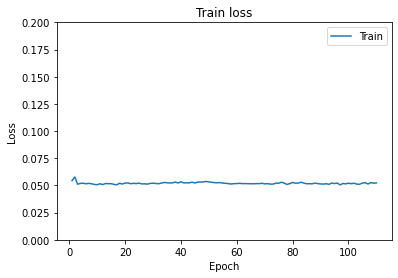

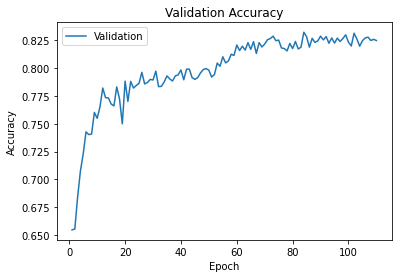

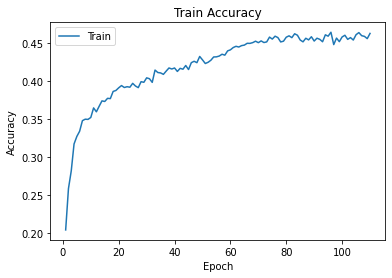

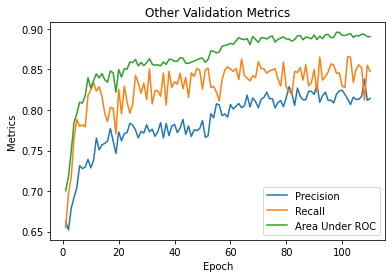

In [ ]:
#Plotting the train/validation accuracies and loss curves:
plt.title("Train loss")
plt.plot(range(1,len(total_triplet_loss_ls)+1), total_triplet_loss_ls, label="Train")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim([0, 0.2])
plt.legend(loc='best')
plt.show()

plt.plot(range(1, len(val_acc_ls)+1), val_acc_ls, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend(loc='best')
plt.show()

plt.plot(range(1,len(train_acc_ls)+1), train_acc_ls, label="Train")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train Accuracy")
plt.legend(loc='best')
plt.show()

plt.title("Other Validation Metrics")
plt.plot(range(1,len(val_precision_ls)+1), val_precision_ls, label="Precision")
plt.plot(range(1,len(val_recall_ls)+1), val_recall_ls, label="Recall")
plt.plot(range(1,len(val_auc_ls)+1), val_auc_ls, label="Area Under ROC")
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.legend(loc='best')
plt.show()

**Printing the final Validation metrics for Inception ResNetV1:**

In [ ]:
PATH='C:\\Users\\bhagyashreekeswani\\Desktop\\DL_Project\\all_checkpoints\\model_training_checkpoints4\\model_InceptionResnetV1_triplet_epoch_39.pt'
final_metrics_inception=torch.load(PATH)['validation_metrics']
print('-----------The final validation metrics for Inception ResnetV1-----------')
print('Accuracy: {:.2f} %'.format(final_metrics_inception[0]*100))
print('Precision: {:.3f}'.format(final_metrics_inception[1]))
print('Recall: {:.3f}'.format(final_metrics_inception[2]))
print('Area Under ROC: {:.3f}'.format(final_metrics_inception[3]))
print('Best distance threshold: {:.3f}'.format(final_metrics_inception[4]))
print('True acceptance rate: {:.6f}'.format(final_metrics_inception[5]))
print('False acceptance rate: {:.6f}'.format(final_metrics_inception[6]))

-----------The final validation metrics for Inception ResnetV1-----------
Accuracy: 82.47 %
Precision: 0.814
Recall: 0.848
Area Under ROC: 0.891
Best distance threshold: 0.732
True acceptance rate: 0.021856
False acceptance rate: 0.001437


## Quantitative Results

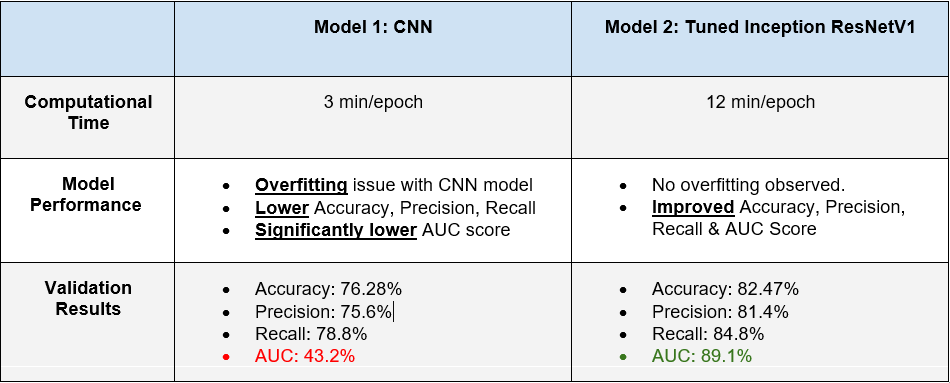

**- As mentioned, we decided to try a more complex architecture, it being a tuned hybrid inception ResNet V1 model which resulted in better performance metrics for our problem. Since the model was significantly more complex, it did take more computational time however showed better results.**

**- We observed overfitting for the CNN model with significantly lower AUC score of 43%. With the improved model, the AUC score increased to 89% and showed good performance on the test set.**

## Best model

**Our best model is:**

- Inception ResNetV1
- Epoch=119 ( that is , epoch 39 from the saved file model_train_checkpoints4) 
- No. of iterations=5000
- Batch size=24
- Learning rate= 0.001

**Let's load the best model from above to test it on the unseen VGG data:**

In [ ]:
PATH='C:\\Users\\bhagyashreekeswani\\Desktop\\DL_Project\\all_checkpoints\\model_training_checkpoints4\\model_InceptionResnetV1_triplet_epoch_39.pt'
pretrained_model.load_state_dict(torch.load(PATH)['model_state_dict'])

<All keys matched successfully>